In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import ast
import itertools
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)


In [8]:
# Load the first dataset (non-censorship scenario)
file_path1 = "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250607_215303_7200s/transactions.csv"
transactions1 = pd.read_csv(file_path1)
transactions1 = transactions1[transactions1['is_proposed']].copy()
transactions1['proposal_delay'] = transactions1['proposed_time'] - transactions1['arrival_time']
transactions1['sanctioned_type'] = transactions1['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
transactions1['experiment'] = 'b0_s0_r0_v0'

# Load the second dataset (censorship scenario)
file_path2 = "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250607_195134_7200s/transactions.csv"
transactions2 = pd.read_csv(file_path2)
transactions2 = transactions2[transactions2['is_proposed']].copy()
transactions2['proposal_delay'] = transactions2['proposed_time'] - transactions2['arrival_time']
transactions2['sanctioned_type'] = transactions2['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
transactions2['experiment'] = 'b5_s5_r5_v2'

# Combine the two datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Check for negative proposal delays
negative_delay_txs = combined_transactions[combined_transactions['proposal_delay'] < 0]
print("Transactions with negative proposal delay:")
print(negative_delay_txs)

# Average within each run first, then average across runs
# Step 1: Compute mean and standard deviation for each run, experiment, and sanctioned type
run_stats = combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type'])['proposal_delay'].agg(['mean', 'std']).reset_index()

# Step 2: Compute the average of the means and stds across runs, for each experiment and sanctioned type
final_stats = run_stats.groupby(['experiment', 'sanctioned_type']).agg({
    'mean': 'mean',
    'std': 'mean'
}).reset_index()

print("Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):")
print(final_stats)


Transactions with negative proposal delay:
Empty DataFrame
Columns: [run_id, tx_id, arrival_time, transaction_type, sanctioned_type, gas_used, base_fee_per_gas, priority_fee_per_gas, priority_fee, gas_fee, proposed_block_id, proposed_builder_id, proposed_builder_policy, selected_relay_id, selected_relay_policy, proposer_validator_id, proposer_validator_is_censoring, proposed_time, confirmed_time, is_proposed, is_confirmed, proposal_delay, experiment]
Index: []

[0 rows x 23 columns]
Proposal Delay Statistics by Experiment and Sanctioned Type (averaged by run_id):
    experiment     sanctioned_type       mean        std
0  b0_s0_r0_v0  Non-sanctioned (0)  15.489594  12.382050
1  b0_s0_r0_v0      Sanctioned (1)  15.837191  12.578596
2  b5_s5_r5_v2  Non-sanctioned (0)  19.504731  38.360716
3  b5_s5_r5_v2      Sanctioned (1)  30.264931  76.281051


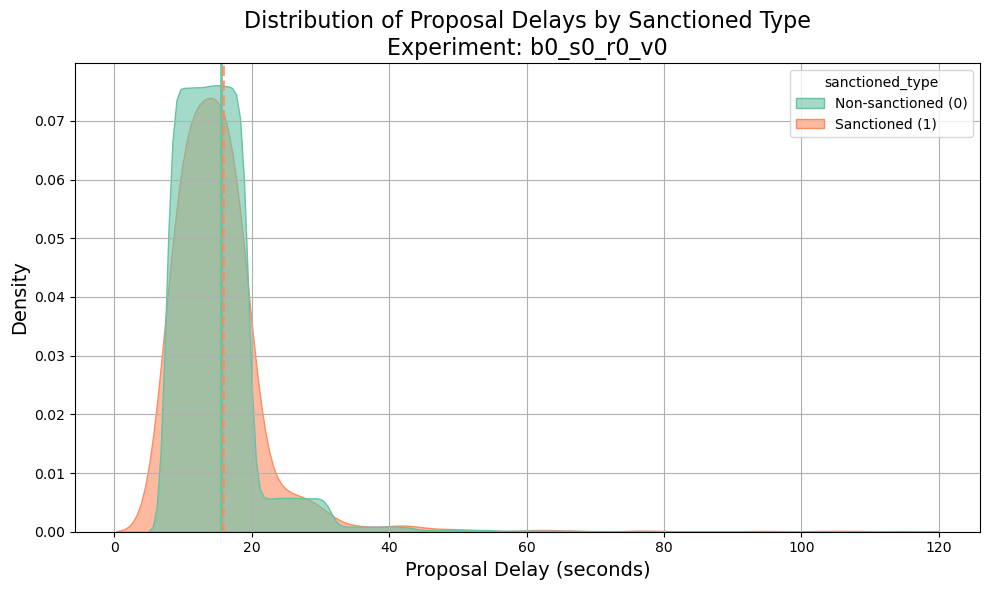

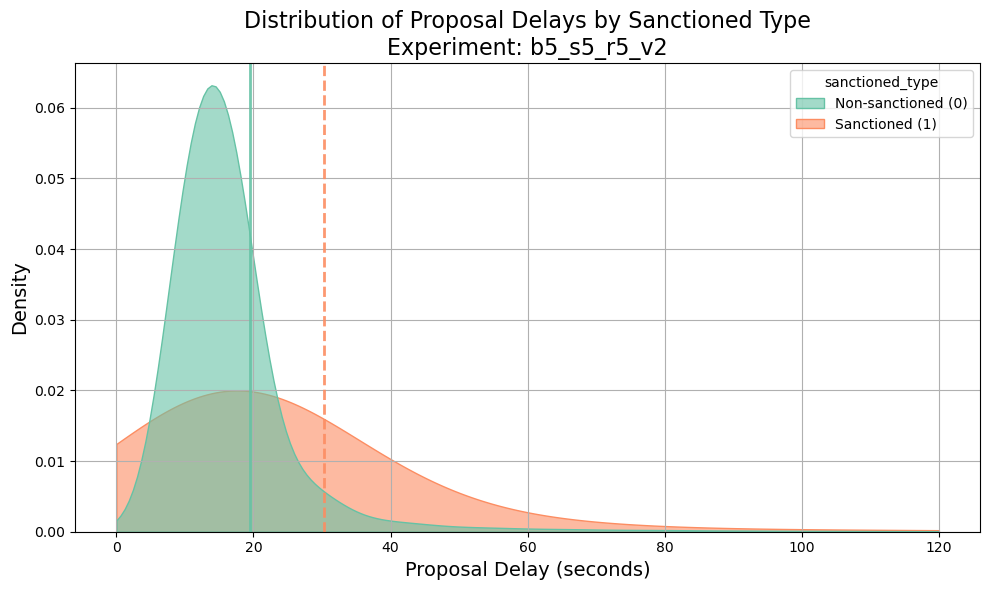

In [9]:

color_palette = sns.color_palette("Set2")
colors = {
    'Non-sanctioned (0)': color_palette[0],
    'Sanctioned (1)': color_palette[1]
}

linestyles = {
    'Non-sanctioned (0)': 'solid',
    'Sanctioned (1)': 'dashed'
}

for exp in combined_transactions['experiment'].unique():
    plt.figure(figsize=(10, 6))
    subset_data = combined_transactions[combined_transactions['experiment'] == exp]

    # KDE plot
    sns.kdeplot(
        data=subset_data,
        x='proposal_delay',
        hue='sanctioned_type',
        fill=True,
        common_norm=False,
        palette=colors,
        alpha=0.6,
        clip=(0, 120)
    )

    # Add vertical lines for the mean
    for stype in subset_data['sanctioned_type'].unique():
        mean_value = final_stats[
            (final_stats['experiment'] == exp) & 
            (final_stats['sanctioned_type'] == stype)
        ]['mean'].values[0]

        plt.axvline(
            mean_value,
            linestyle=linestyles[stype],
            linewidth=2,
            color=colors[stype],
            alpha=0.9  
        )

    plt.xlabel('Proposal Delay (seconds)', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.title(f'Distribution of Proposal Delays by Sanctioned Type\nExperiment: {exp}', fontsize=16)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


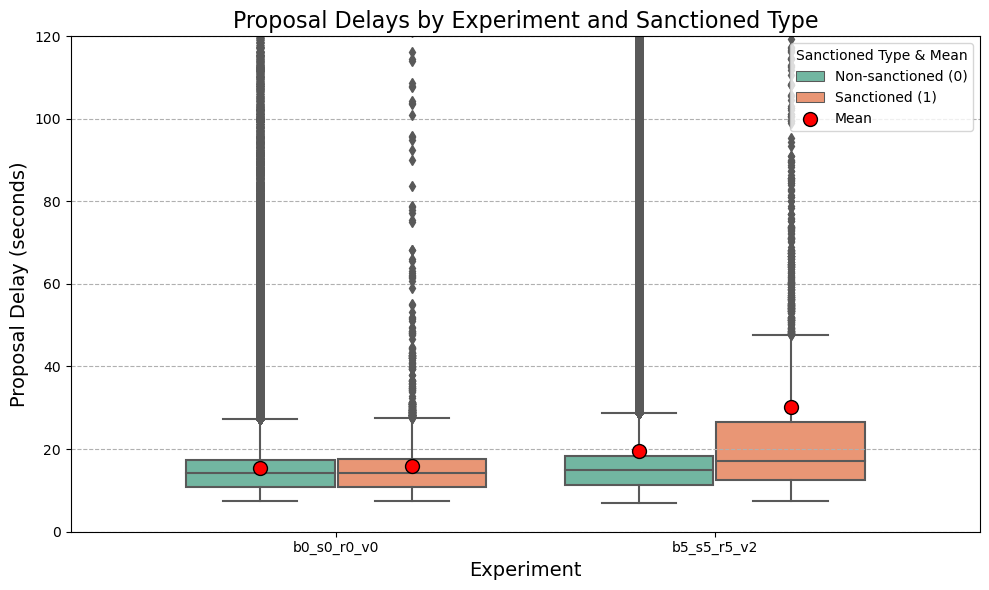

In [10]:
# Assume combined_transactions and final_stats already exist
# Structure of final_stats:
# experiment | sanctioned_type | mean | std
# The mean in this plot is based on per-run averages, then averaged across runs

plt.figure(figsize=(10, 6))

# Draw boxplot first
ax = sns.boxplot(
    x='experiment', 
    y='proposal_delay', 
    hue='sanctioned_type', 
    data=combined_transactions, 
    palette='Set2'
)

# Get boxplot positions (ticks are at 0 and 1 for two experiments)
positions = {'b0_s0_r0_v0': 0, 'b5_s5_r5_v2': 1}
offset = {'Non-sanctioned (0)': -0.2, 'Sanctioned (1)': 0.2}

# Overlay the mean as red scatter points
for idx, row in final_stats.iterrows():
    x_pos = positions[row['experiment']] + offset[row['sanctioned_type']]
    plt.scatter(
        x=x_pos, 
        y=row['mean'], 
        color='red', 
        edgecolor='black', 
        s=100,
        zorder=5,
        label='Mean' if idx == 0 else ""
    )

# Add legend if not already included
handles, labels = ax.get_legend_handles_labels()
if 'Mean' not in labels:
    handles.append(plt.Line2D([], [], color='red', marker='o', linestyle='', markersize=10, label='Mean'))
    labels.append('Mean')

plt.legend(handles=handles, labels=labels, title='Sanctioned Type & Mean', loc='upper right')

# Set additional plot parameters
plt.xlabel('Experiment', fontsize=14)
plt.ylabel('Proposal Delay (seconds)', fontsize=14)
plt.title('Proposal Delays by Experiment and Sanctioned Type', fontsize=16)
plt.ylim(0, 120)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


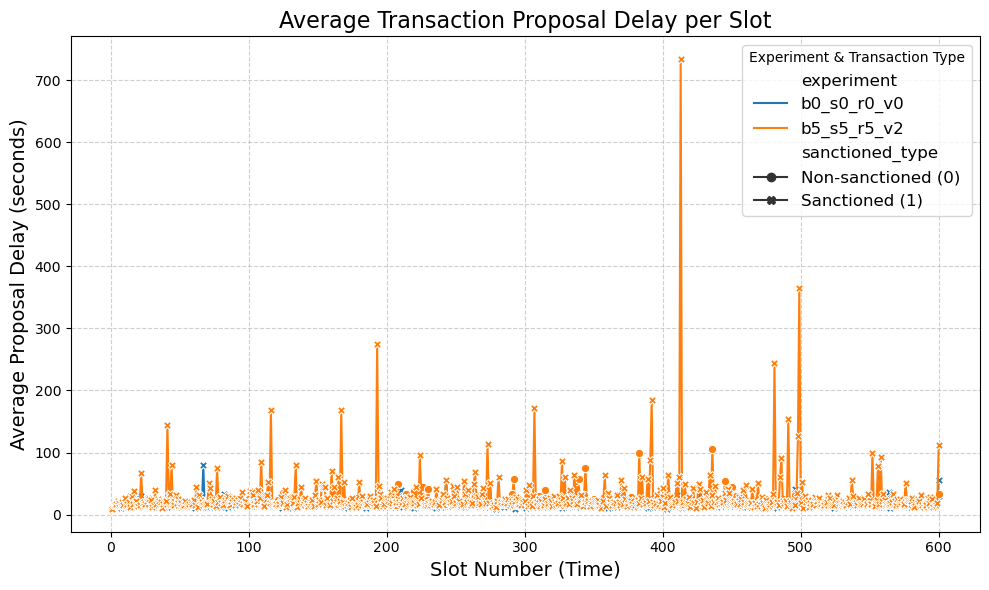

In [11]:


# Function to load and preprocess transaction data
def load_and_prepare(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[df['is_proposed']].copy()
    df['proposal_delay'] = df['proposed_time'] - df['arrival_time']
    df['sanctioned_type'] = df['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    df['experiment'] = experiment_label
    df['slot'] = ((df['proposed_time'] - 1) // 12).astype(int)  
    return df

# Load the two datasets
transactions1 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250607_215303_7200s/transactions.csv", 
    'b0_s0_r0_v0'
)

transactions2 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250607_195134_7200s/transactions.csv", 
    'b5_s5_r5_v2'
)

# Combine the datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Step 1: Compute average delay per run_id, experiment, slot, and transaction type
slot_run_stats = combined_transactions.groupby(
    ['experiment', 'run_id', 'slot', 'sanctioned_type']
)['proposal_delay'].mean().reset_index(name='mean_delay')

# Step 2: Average over runs for each slot and transaction type
slot_avg_stats = slot_run_stats.groupby(
    ['experiment', 'slot', 'sanctioned_type']
)['mean_delay'].mean().reset_index()

# Plot average delay across slots for all types
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=slot_avg_stats,
    x='slot',
    y='mean_delay',
    hue='experiment',
    style='sanctioned_type',
    markers=True,
    dashes=False
)

plt.xlabel("Slot Number (Time)", fontsize=14)
plt.ylabel("Average Proposal Delay (seconds)", fontsize=14)
plt.title("Average Transaction Proposal Delay per Slot", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Experiment & Transaction Type", fontsize=12)
plt.tight_layout()

plt.show()


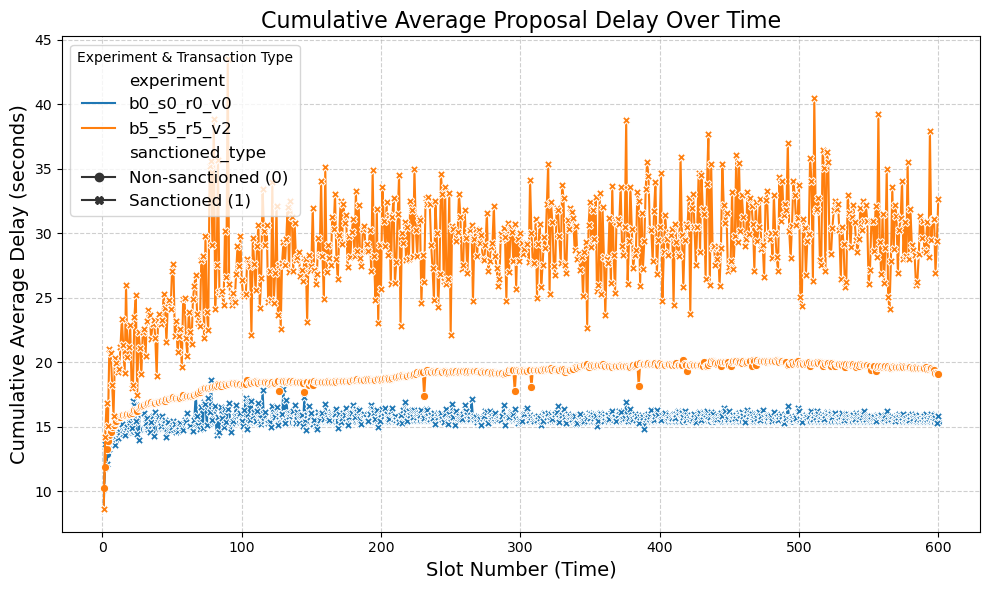

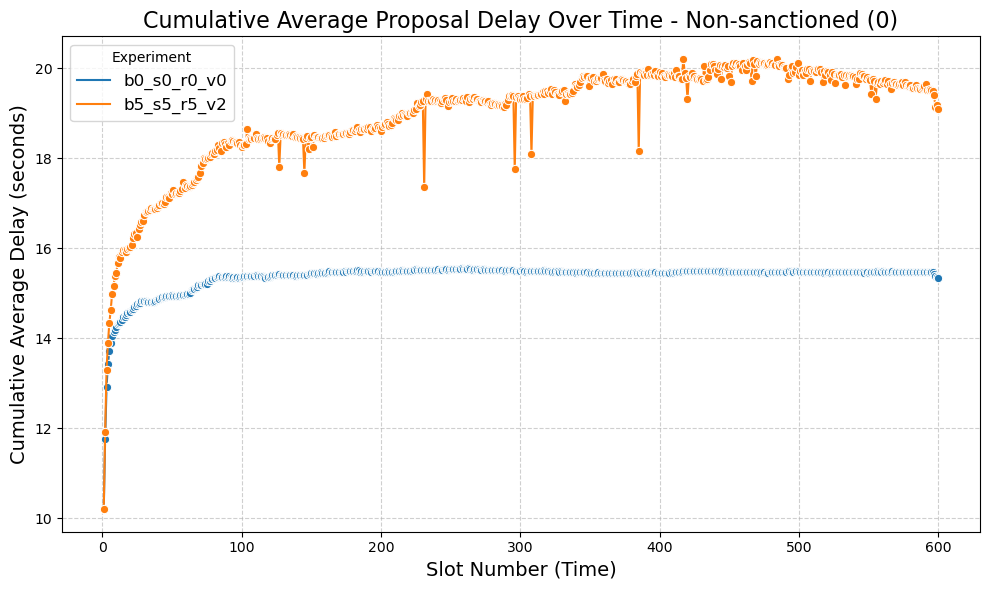

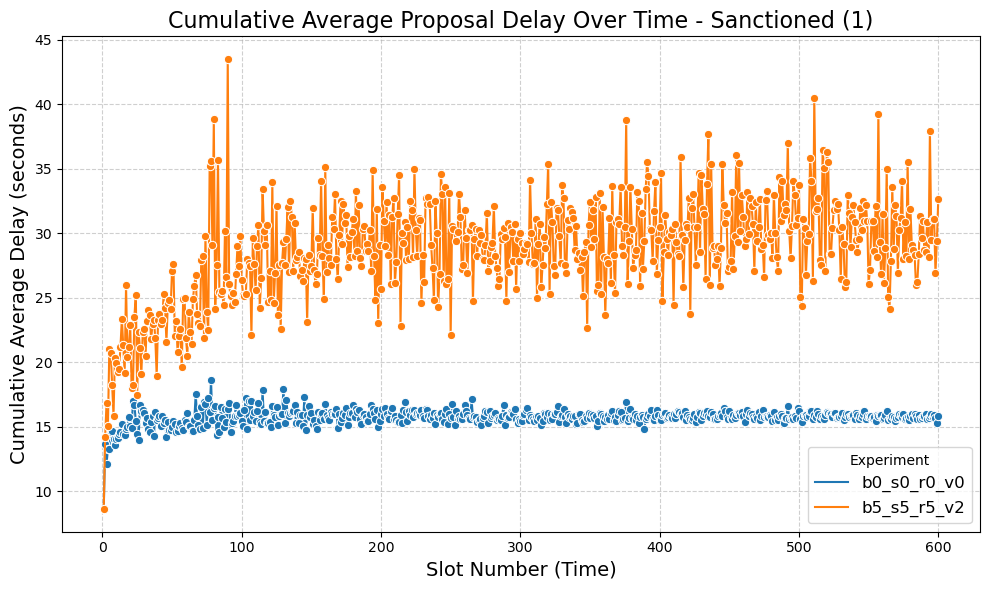

In [12]:


# Data loading function
def load_and_prepare(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[df['is_proposed']].copy()
    df['proposal_delay'] = df['proposed_time'] - df['arrival_time']
    df['sanctioned_type'] = df['sanctioned_type'].map({0: 'Non-sanctioned (0)', 1: 'Sanctioned (1)'})
    df['experiment'] = experiment_label
    df['slot'] = ((df['proposed_time'] - 1) // 12).astype(int)
    return df

# Load two datasets
transactions1 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250607_215303_7200s/transactions.csv", 
    'b0_s0_r0_v0'
)

transactions2 = load_and_prepare(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250607_195134_7200s/transactions.csv", 
    'b5_s5_r5_v2'
)

# Combine datasets
combined_transactions = pd.concat([transactions1, transactions2], ignore_index=True)

# Store cumulative statistics for each group
cumulative_results = []

# Compute cumulative average delay per (experiment, run_id, transaction type) group
for (experiment, run_id, sanctioned_type), group in combined_transactions.groupby(['experiment', 'run_id', 'sanctioned_type']):
    group_sorted = group.sort_values('slot')
    group_sorted['cumulative_mean_delay'] = group_sorted['proposal_delay'].expanding().mean()
    cumulative_results.append(group_sorted[['experiment', 'run_id', 'sanctioned_type', 'slot', 'cumulative_mean_delay']])

# Combine all cumulative results
cumulative_df = pd.concat(cumulative_results)

# Then compute the average cumulative delay across all runs
final_cumulative_stats = cumulative_df.groupby(['experiment', 'slot', 'sanctioned_type'])['cumulative_mean_delay'].mean().reset_index()

# Plot cumulative delay curves for sanctioned and non-sanctioned transactions
transaction_types = final_cumulative_stats['sanctioned_type'].unique()


plt.figure(figsize=(10, 6))

# Use different line styles to distinguish sanctioned_type and experiment
sns.lineplot(
    data=final_cumulative_stats,
    x='slot',
    y='cumulative_mean_delay',
    hue='experiment',
    style='sanctioned_type',
    markers=True,
    dashes=False
)

plt.xlabel("Slot Number (Time)", fontsize=14)
plt.ylabel("Cumulative Average Delay (seconds)", fontsize=14)
plt.title("Cumulative Average Proposal Delay Over Time", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title="Experiment & Transaction Type", fontsize=12)
plt.tight_layout()
plt.show()



for tx_type in transaction_types:
    plt.figure(figsize=(10, 6))
    subset = final_cumulative_stats[final_cumulative_stats['sanctioned_type'] == tx_type]

    sns.lineplot(
        data=subset,
        x='slot',
        y='cumulative_mean_delay',
        hue='experiment',
        marker='o'
    )

    plt.xlabel("Slot Number (Time)", fontsize=14)
    plt.ylabel("Cumulative Average Delay (seconds)", fontsize=14)
    plt.title(f"Cumulative Average Proposal Delay Over Time - {tx_type}", fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Experiment", fontsize=12)
    plt.tight_layout()
    plt.show()


Average number and ratio of empty blocks per run for each experiment:
    experiment  empty_blocks_count  empty_block_ratio
0  b0_s0_r0_v0                 0.2           0.000333
1  b5_s5_r5_v2                 2.5           0.004167


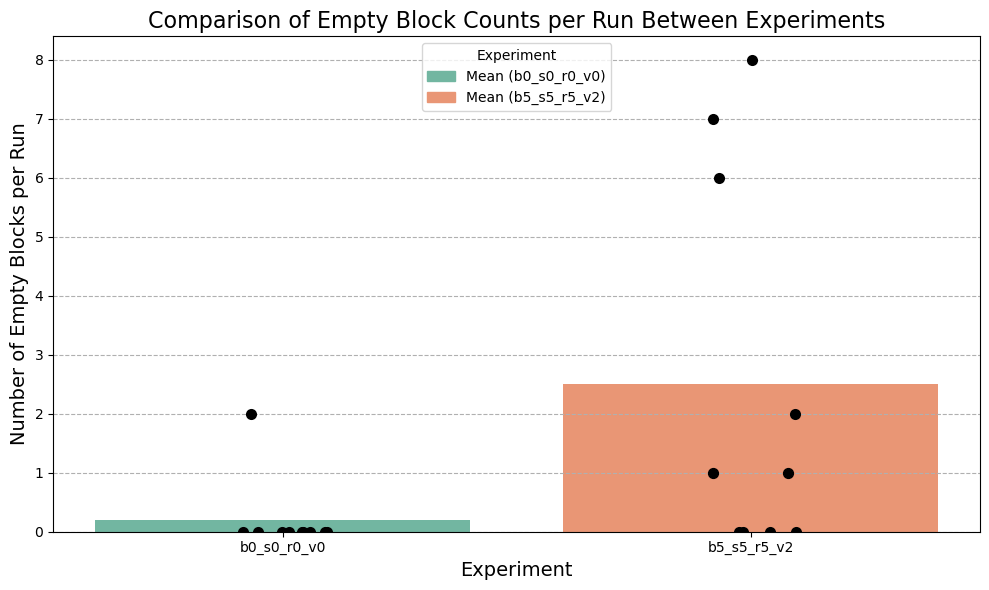


Data used for plotting (combined_counts_ratios):
        run_id  empty_blocks_count  empty_block_ratio   experiment
run_id                                                            
1            1                   0           0.000000  b0_s0_r0_v0
2            2                   0           0.000000  b0_s0_r0_v0
3            3                   0           0.000000  b0_s0_r0_v0
4            4                   0           0.000000  b0_s0_r0_v0
5            5                   0           0.000000  b0_s0_r0_v0
6            6                   0           0.000000  b0_s0_r0_v0
7            7                   2           0.003333  b0_s0_r0_v0
8            8                   0           0.000000  b0_s0_r0_v0
9            9                   0           0.000000  b0_s0_r0_v0
10          10                   0           0.000000  b0_s0_r0_v0
1            1                   7           0.011667  b5_s5_r5_v2
2            2                   2           0.003333  b5_s5_r5_v2
3           

In [13]:

import numpy as np
import matplotlib.patches as mpatches

# Load data
blocks1_original = pd.read_csv("simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250607_215303_7200s/blocks.csv")
blocks2_original = pd.read_csv("simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250607_195134_7200s/blocks.csv")

# Count and ratio of empty blocks per run
def calculate_empty_block_counts_ratios(blocks, experiment_name):
    all_run_ids = blocks['run_id'].unique()

    empty_blocks_per_run = blocks[blocks['builder_id'] == "PROPOSER"].groupby('run_id').size().reindex(all_run_ids, fill_value=0)
    total_proposed_blocks_per_run = blocks[blocks['is_proposed']].groupby('run_id').size().reindex(all_run_ids, fill_value=0)
    
    empty_block_ratio = empty_blocks_per_run / total_proposed_blocks_per_run

    return pd.DataFrame({
        'run_id': all_run_ids,
        'empty_blocks_count': empty_blocks_per_run,
        'empty_block_ratio': empty_block_ratio,
        'experiment': experiment_name
    })

# Calculate statistics for both experiments
empty_counts_ratios_exp1 = calculate_empty_block_counts_ratios(blocks1_original, 'b0_s0_r0_v0')
empty_counts_ratios_exp2 = calculate_empty_block_counts_ratios(blocks2_original, 'b5_s5_r5_v2')

# Merge data
combined_counts_ratios = pd.concat([empty_counts_ratios_exp1, empty_counts_ratios_exp2])

# Calculate averages
avg_results = combined_counts_ratios.groupby('experiment').agg({
    'empty_blocks_count': 'mean',
    'empty_block_ratio': 'mean'
}).reset_index()

# Display average empty block count and ratio
print("Average number and ratio of empty blocks per run for each experiment:")
print(avg_results)


plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='experiment',
    y='empty_blocks_count',
    data=combined_counts_ratios,
    estimator='mean',
    palette='Set2',
    alpha=1.0,
    ci=None
)

x_positions = {'b0_s0_r0_v0': 0, 'b5_s5_r5_v2': 1}

# Add individual points (stripplot), excluding outliers in selected runs
sns.stripplot(
    x='experiment',
    y='empty_blocks_count',
    data=combined_counts_ratios[~(
        ((combined_counts_ratios['experiment'] == 'b5_s5_r5_v2') &
         (combined_counts_ratios['run_id'].isin([8, 10])))
    )],
    color='black',
    size=8,
    jitter=True
)

# Add manually selected outliers as individual points
exp = 'b5_s5_r5_v2'
y_8 = combined_counts_ratios.query("experiment == @exp and run_id == 8")['empty_blocks_count'].iloc[0]
y_10 = combined_counts_ratios.query("experiment == @exp and run_id == 10")['empty_blocks_count'].iloc[0]
plt.scatter(
    x=x_positions[exp] - 0.08, y=y_8, color='black', s=50, zorder=10
)
plt.scatter(
    x=x_positions[exp] + 0.08, y=y_10, color='black', s=50, zorder=10
)

plt.ylabel('Number of Empty Blocks per Run', fontsize=14)
plt.xlabel('Experiment', fontsize=14)
plt.title('Comparison of Empty Block Counts per Run Between Experiments', fontsize=16)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()


# Manually add legend to explain the bar colors
bar_colors = [bar.get_facecolor() for bar in ax.patches[:2]]
legend_elements = [
    mpatches.Patch(color=bar_colors[0], label='Mean (b0_s0_r0_v0)'),
    mpatches.Patch(color=bar_colors[1], label='Mean (b5_s5_r5_v2)')
]
plt.legend(handles=legend_elements, title='Experiment', loc='upper center')

plt.show()


# Print the data used for plotting
print("\nData used for plotting (combined_counts_ratios):")
print(combined_counts_ratios)

Empty blocks validator info for experiment: b0_s0_r0_v0 (300 slots)
        run_id    block_id  proposer_validator_id  \
125620       7  PROPOSER_1                    5.0   
125621       7  PROPOSER_2                    2.0   

       proposer_validator_is_censoring  
125620                           False  
125621                           False  
Empty blocks validator info for experiment: b5_s5_r5_v2 (300 slots)
        run_id    block_id  proposer_validator_id  \
60187        4  PROPOSER_1                    0.0   
118953       7  PROPOSER_1                    5.0   
118954       7  PROPOSER_2                    2.0   

       proposer_validator_is_censoring  
60187                             True  
118953                           False  
118954                           False  
Empty blocks validator info for experiment: b0_s0_r0_v0 (600 slots)
        run_id    block_id  proposer_validator_id  \
251620       7  PROPOSER_1                    8.0   
251621       7  PROPOSER_2    

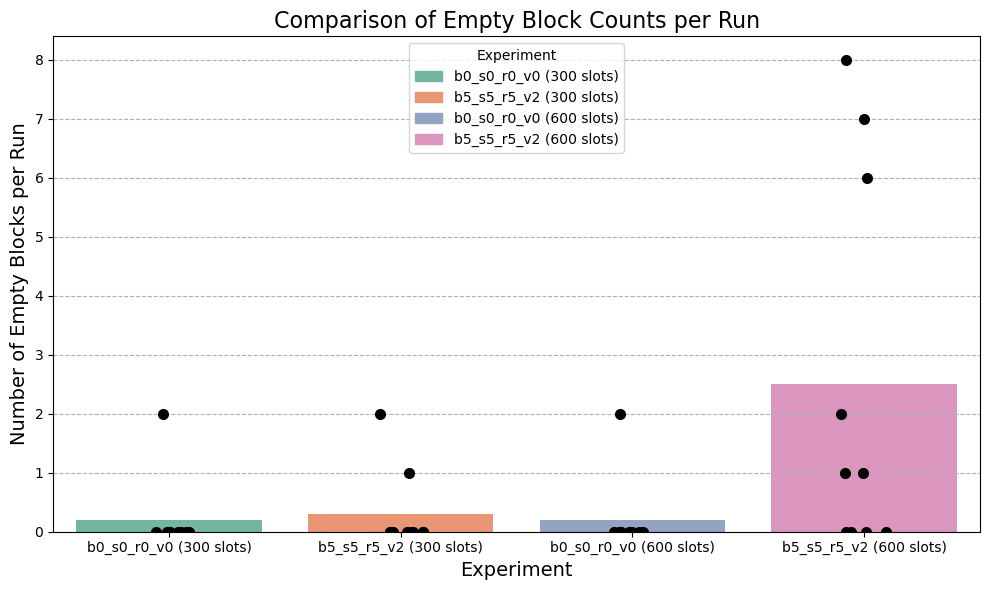

        run_id  empty_blocks_count  empty_block_ratio               experiment
run_id                                                                        
1            1                   0           0.000000  b0_s0_r0_v0 (300 slots)
2            2                   0           0.000000  b0_s0_r0_v0 (300 slots)
3            3                   0           0.000000  b0_s0_r0_v0 (300 slots)
4            4                   0           0.000000  b0_s0_r0_v0 (300 slots)
5            5                   0           0.000000  b0_s0_r0_v0 (300 slots)
6            6                   0           0.000000  b0_s0_r0_v0 (300 slots)
7            7                   2           0.006667  b0_s0_r0_v0 (300 slots)
8            8                   0           0.000000  b0_s0_r0_v0 (300 slots)
9            9                   0           0.000000  b0_s0_r0_v0 (300 slots)
10          10                   0           0.000000  b0_s0_r0_v0 (300 slots)
1            1                   0           0.00000

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Load data
blocks_files = [
    ("simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv", "b0_s0_r0_v0 (300 slots)"),
    ("simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv", "b5_s5_r5_v2 (300 slots)"),
    ("simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250607_215303_7200s/blocks.csv", "b0_s0_r0_v0 (600 slots)"),
    ("simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250607_195134_7200s/blocks.csv", "b5_s5_r5_v2 (600 slots)")
]

def calculate_empty_block_counts_ratios(blocks, experiment_name):
    all_run_ids = blocks['run_id'].unique()
    empty_blocks_df = blocks[blocks['builder_id'] == "PROPOSER"]

    # Print empty blocks validator info
    print(f"Empty blocks validator info for experiment: {experiment_name}")
    print(empty_blocks_df[['run_id', 'block_id', 'proposer_validator_id', 'proposer_validator_is_censoring']])

    empty_blocks_per_run = empty_blocks_df.groupby('run_id').size().reindex(all_run_ids, fill_value=0)
    total_proposed_blocks_per_run = blocks[blocks['is_proposed']].groupby('run_id').size().reindex(all_run_ids, fill_value=0)
    empty_block_ratio = empty_blocks_per_run / total_proposed_blocks_per_run

    return pd.DataFrame({
        'run_id': all_run_ids,
        'empty_blocks_count': empty_blocks_per_run,
        'empty_block_ratio': empty_block_ratio,
        'experiment': experiment_name
    })

combined_counts_ratios = pd.DataFrame()
for file, exp_name in blocks_files:
    blocks_df = pd.read_csv(file)
    combined_counts_ratios = pd.concat([combined_counts_ratios, calculate_empty_block_counts_ratios(blocks_df, exp_name)])

# Plotting the results
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='experiment',
    y='empty_blocks_count',
    data=combined_counts_ratios,
    estimator='mean',
    palette='Set2',
    ci=None
)

sns.stripplot(
    x='experiment',
    y='empty_blocks_count',
    data=combined_counts_ratios,
    color='black',
    size=8,
    jitter=True
)

plt.ylabel('Number of Empty Blocks per Run', fontsize=14)
plt.xlabel('Experiment', fontsize=14)
plt.title('Comparison of Empty Block Counts per Run', fontsize=16)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()

# Legend
bar_colors = [bar.get_facecolor() for bar in ax.patches[:4]]
legend_elements = [mpatches.Patch(color=bar_colors[i], label=blocks_files[i][1]) for i in range(4)]
plt.legend(handles=legend_elements, title='Experiment', loc='upper center')

plt.show()

# Print the data used for plotting
print(combined_counts_ratios)

In [17]:
import pandas as pd

def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    # if tag is not None:
    #     df['experiment'] = tag
    
    return df

def node_level_block_counts(df):
    return df.groupby(['run_id', 'builder_id']).size().reset_index(name='block_count')

def prepare_builder_counts(df, experiment_label):
    builder_counts = node_level_block_counts(df)
    policy_map = df[['builder_id', 'builder_policy']].drop_duplicates()
    builder_counts = pd.merge(builder_counts, policy_map, on='builder_id', how='left')
    builder_counts['experiment'] = experiment_label
    return builder_counts

blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv"
)
blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"
)
blocks3 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v5_uniform_start_20250610_123711/blocks.csv"
)

builder_counts1 = prepare_builder_counts(blocks1, 'b0_s0_r0_v0')
builder_counts2 = prepare_builder_counts(blocks2, 'b5_s5_r5_v2')
builder_counts3 = prepare_builder_counts(blocks3, 'b5_s5_r5_v5')

builder_node_counts = pd.concat([builder_counts1, builder_counts2, builder_counts3], ignore_index=True)

strategy_means_per_run = builder_node_counts.groupby(['experiment', 'run_id', 'builder_policy'])['block_count'].mean().reset_index()
strategy_overall_stats = strategy_means_per_run.groupby(['experiment', 'builder_policy'])['block_count'].agg(['mean', 'std'])

print(strategy_overall_stats)


                             mean       std
experiment  builder_policy                 
b0_s0_r0_v0 non             14.99  0.031623
b5_s5_r5_v2 non             21.49  0.856933
            strict          12.28  1.657843
            weak             4.78  0.856089
b5_s5_r5_v5 non             15.08  1.205358
            strict          23.32  2.177052
            weak             5.48  1.163138


Number of unique builder nodes per strategy in each experiment:
 experiment   builder_policy
b0_s0_r0_v0  non               20
b5_s5_r5_v2  non               10
             strict             5
             weak               5
b5_s5_r5_v5  non               10
             strict             5
             weak               5
dtype: int64

Builder strategy distribution in experiment b0_s0_r0_v0:
builder_id  builder_policy
0           non               1
1           non               1
8           non               1
7           non               1
6           non               1
5           non               1
4           non               1
3           non               1
2           non               1
19          non               1
18          non               1
17          non               1
16          non               1
15          non               1
14          non               1
13          non               1
12          non               1
11          non            

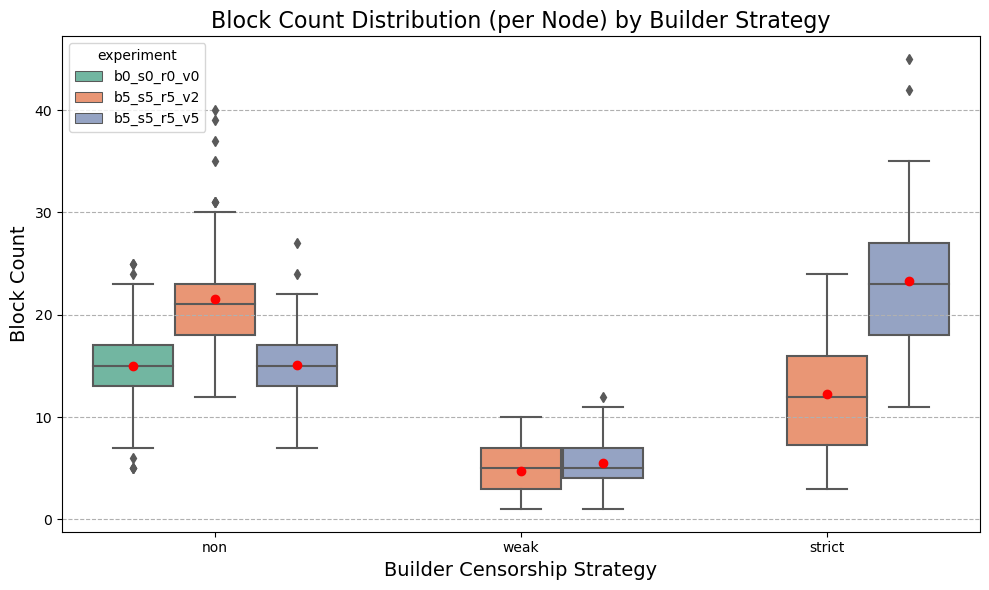

experiment   builder_policy
b0_s0_r0_v0  non               14.99000
b5_s5_r5_v2  non               21.49000
             strict            12.28000
             weak               4.77551
b5_s5_r5_v5  non               15.08000
             strict            23.32000
             weak               5.48000
Name: block_count, dtype: float64


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    
    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    
    # if tag is not None:
    #     df['experiment'] = tag
    
    return df

# Load blocks data for three experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

blocks3 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v5_uniform_start_20250610_123711/blocks.csv",
    'b5_s5_r5_v5'
)

# Function to count blocks per node
def node_level_block_counts(df):
    return df.groupby(['run_id', 'builder_id']).size().reset_index(name='block_count')

# Experiment 1 statistics (adding experiment label)
builder_counts1 = node_level_block_counts(blocks1)
policy_map1 = blocks1[['builder_id', 'builder_policy']].drop_duplicates()
builder_counts1 = pd.merge(builder_counts1, policy_map1, on='builder_id', how='left')
builder_counts1['experiment'] = 'b0_s0_r0_v0'

# Experiment 2 statistics (adding experiment label)
builder_counts2 = node_level_block_counts(blocks2)
policy_map2 = blocks2[['builder_id', 'builder_policy']].drop_duplicates()
builder_counts2 = pd.merge(builder_counts2, policy_map2, on='builder_id', how='left')
builder_counts2['experiment'] = 'b5_s5_r5_v2'

# Experiment 3 statistics (adding experiment label)
builder_counts3 = node_level_block_counts(blocks3)
policy_map3 = blocks3[['builder_id', 'builder_policy']].drop_duplicates()
builder_counts3 = pd.merge(builder_counts3, policy_map3, on='builder_id', how='left')
builder_counts3['experiment'] = 'b5_s5_r5_v5'

# Combine all builder counts into a single DataFrame
builder_node_counts = pd.concat([builder_counts1, builder_counts2, builder_counts3], ignore_index=True)

# Correctly count the number of unique builders per strategy per experiment for verification
builder_unique_counts = builder_node_counts[['experiment', 'builder_id', 'builder_policy']].drop_duplicates()
builder_unique_summary = builder_unique_counts.groupby(['experiment', 'builder_policy']).size()
print("Number of unique builder nodes per strategy in each experiment:\n", builder_unique_summary)

# Verify distribution in Experiment 1 (b0_s0_r0_v0)
print("\nBuilder strategy distribution in experiment b0_s0_r0_v0:")
print(blocks1[['builder_id', 'builder_policy']].drop_duplicates().value_counts())

print("\nNumber of blocks proposed in each run in experiment b0_s0_r0_v0:")
print(blocks1.groupby('run_id').size())

print("\nAverage number of blocks proposed per builder in b0_s0_r0_v0:")
print(builder_counts1.groupby('builder_id')['block_count'].mean())

# Define strategy order for consistent plotting
policy_order = ['non', 'weak', 'strict']

# Boxplot of block count per builder, colored by experiment
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=builder_node_counts,
    x='builder_policy',
    y='block_count',
    order=policy_order,
    hue='experiment',
    palette='Set2',
    showmeans=True,
    meanprops={"marker":"o", "markerfacecolor":"red", "markeredgecolor":"red"}
)
plt.title('Block Count Distribution (per Node) by Builder Strategy', fontsize=16)
plt.ylabel('Block Count', fontsize=14)
plt.xlabel('Builder Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(builder_node_counts.groupby(['experiment', 'builder_policy'])['block_count'].mean())


In [19]:
import pandas as pd


# Force ID fields to be treated as strings
def load_blocks(filepath, tag):
    df = pd.read_csv(filepath, dtype={
        'selected_relay_id': str,
        'proposer_validator_id': str,
        'builder_id': str
    })
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['experiment'] = tag

    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    df['proposer_validator_policy'] = df['proposer_validator_is_censoring'].map({False: 'non', True: 'censoring'})
    return df


# Function to count number of blocks per node
def node_level_block_counts(df, node_field, policy_field):
    node_counts = df.groupby(['run_id', node_field]).size().reset_index(name='block_count')
    policy_mapping = df[[node_field, policy_field]].drop_duplicates()
    return pd.merge(node_counts, policy_mapping, on=node_field, how='left')

# Load data
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)
blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)
blocks3 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v5_uniform_start_20250610_123711/blocks.csv",
    'b5_s5_r5_v5'
)

# Statistics for relay nodes
def relay_stats(blocks, experiment_label):
    relay_counts = node_level_block_counts(blocks, 'selected_relay_id', 'selected_relay_policy')
    relay_counts['experiment'] = experiment_label
    return relay_counts

relay_counts_all = pd.concat([
    relay_stats(blocks1, 'b0_s0_r0_v0'),
    relay_stats(blocks2, 'b5_s5_r5_v2'),
    relay_stats(blocks3, 'b5_s5_r5_v5')
], ignore_index=True)

relay_run_stats = relay_counts_all.groupby(['experiment', 'run_id', 'selected_relay_policy'])['block_count'].agg(['mean', 'std']).reset_index()
relay_overall_stats = relay_run_stats.groupby(['experiment', 'selected_relay_policy'])[['mean', 'std']].mean()

print("Relay strategy overall stats:")
print(relay_overall_stats)

# Statistics for validator nodes
def validator_stats(blocks, experiment_label):
    validator_counts = node_level_block_counts(blocks, 'proposer_validator_id', 'proposer_validator_policy')
    validator_counts['experiment'] = experiment_label
    return validator_counts

validator_counts_all = pd.concat([
    validator_stats(blocks1, 'b0_s0_r0_v0'),
    validator_stats(blocks2, 'b5_s5_r5_v2'),
    validator_stats(blocks3, 'b5_s5_r5_v5')
], ignore_index=True)

validator_run_stats = validator_counts_all.groupby(['experiment', 'run_id', 'proposer_validator_policy'])['block_count'].agg(['mean', 'std']).reset_index()
validator_overall_stats = validator_run_stats.groupby(['experiment', 'proposer_validator_policy'])[['mean', 'std']].mean()

print("\nValidator strategy overall stats:")
print(validator_overall_stats)


Relay strategy overall stats:
                                    mean        std
experiment  selected_relay_policy                  
b0_s0_r0_v0 non                    29.98  12.913390
b5_s5_r5_v2 censoring              12.44   6.178896
            non                    47.50  16.809548
b5_s5_r5_v5 censoring              28.24  10.714664
            non                    30.72  12.902726

Validator strategy overall stats:
                                          mean       std
experiment  proposer_validator_policy                   
b0_s0_r0_v0 non                        29.9800  5.933275
b5_s5_r5_v2 censoring                  29.1000  3.676955
            non                        30.1875  6.176307
b5_s5_r5_v5 censoring                  28.0400  4.926747
            non                        30.9200  6.315229


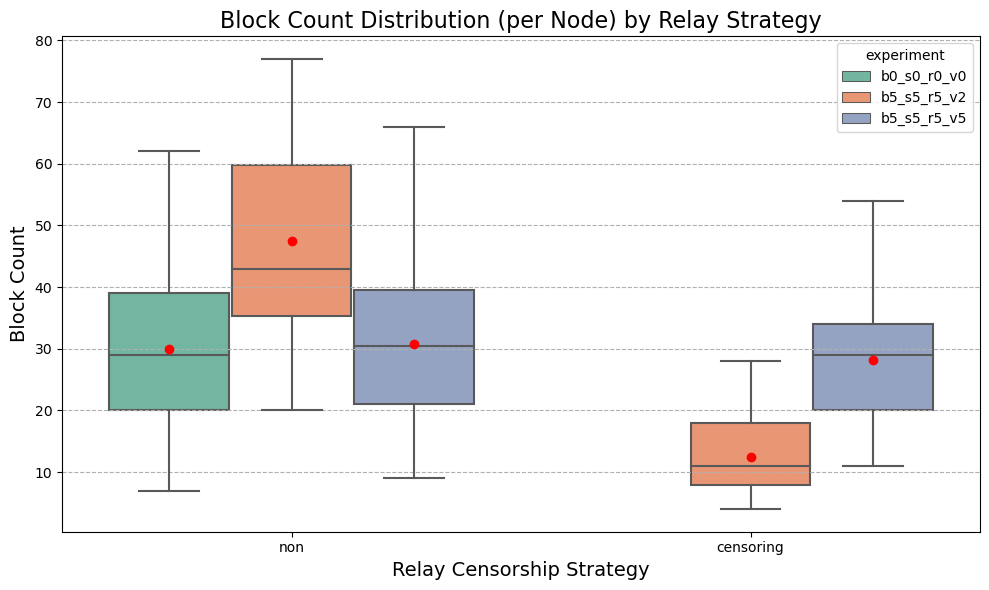

experiment   selected_relay_policy
b0_s0_r0_v0  non                      29.98
b5_s5_r5_v2  censoring                12.44
             non                      47.50
b5_s5_r5_v5  censoring                28.24
             non                      30.72
Name: block_count, dtype: float64


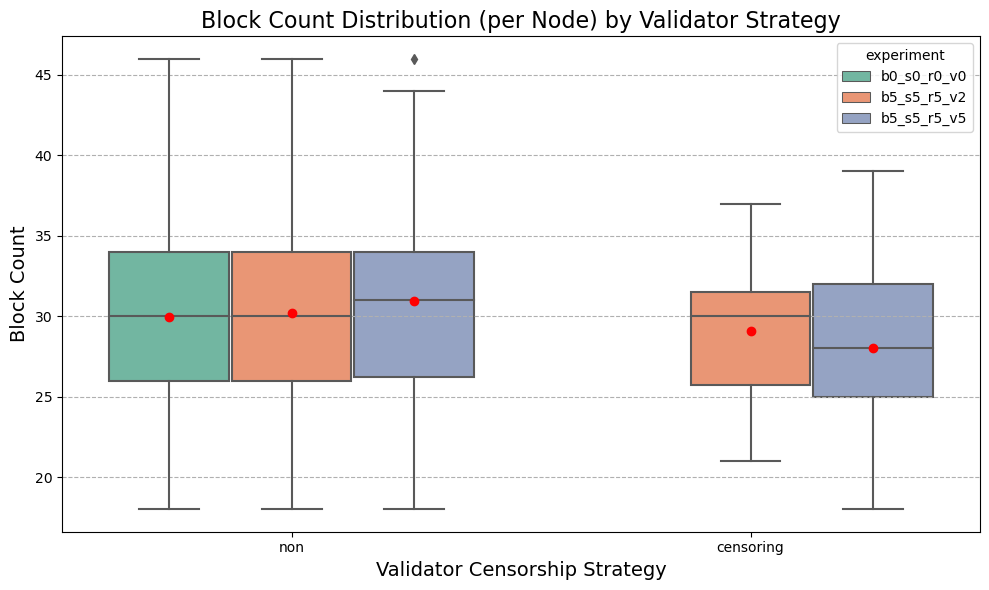

experiment   proposer_validator_policy
b0_s0_r0_v0  non                          29.9800
b5_s5_r5_v2  censoring                    29.1000
             non                          30.1875
b5_s5_r5_v5  censoring                    28.0400
             non                          30.9200
Name: block_count, dtype: float64


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Force ID fields to be treated as strings
def load_blocks(filepath, tag):
    df = pd.read_csv(filepath, dtype={
        'selected_relay_id': str,
        'proposer_validator_id': str,
        'builder_id': str
    })
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['experiment'] = tag

    df['builder_id'] = df['builder_id'].astype(str).str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].astype(str).str.strip()
    df['proposer_validator_id'] = df['proposer_validator_id'].astype(str).str.strip()
    df['proposer_validator_policy'] = df['proposer_validator_is_censoring'].map({False: 'non', True: 'censoring'})
    return df


# Load data
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b5_s5_r5_v2'
)

blocks3 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v5_uniform_start_20250610_123711/blocks.csv",
    'b5_s5_r5_v5'
)

# Function to count number of blocks per node
def node_level_block_counts(df, node_field, policy_field):
    node_counts = df.groupby(['run_id', node_field]).size().reset_index(name='block_count')
    policy_mapping = df[[node_field, policy_field]].drop_duplicates()
    return pd.merge(node_counts, policy_mapping, on=node_field, how='left')

# Statistics for relay nodes
relay_counts1 = node_level_block_counts(blocks1, 'selected_relay_id', 'selected_relay_policy')
relay_counts1['experiment'] = 'b0_s0_r0_v0'

relay_counts2 = node_level_block_counts(blocks2, 'selected_relay_id', 'selected_relay_policy')
relay_counts2['experiment'] = 'b5_s5_r5_v2'

relay_counts3 = node_level_block_counts(blocks3, 'selected_relay_id', 'selected_relay_policy')
relay_counts3['experiment'] = 'b5_s5_r5_v5'

relay_node_counts = pd.concat([relay_counts1, relay_counts2, relay_counts3], ignore_index=True)
relay_policy_order = ['non', 'censoring']

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=relay_node_counts,
    x='selected_relay_policy',
    y='block_count',
    order=relay_policy_order,
    hue='experiment',
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Count Distribution (per Node) by Relay Strategy', fontsize=16)
plt.ylabel('Block Count', fontsize=14)
plt.xlabel('Relay Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(relay_node_counts.groupby(['experiment', 'selected_relay_policy'])['block_count'].mean())

# Statistics for validator nodes
validator_counts1 = node_level_block_counts(blocks1, 'proposer_validator_id', 'proposer_validator_policy')
validator_counts1['experiment'] = 'b0_s0_r0_v0'

validator_counts2 = node_level_block_counts(blocks2, 'proposer_validator_id', 'proposer_validator_policy')
validator_counts2['experiment'] = 'b5_s5_r5_v2'

validator_counts3 = node_level_block_counts(blocks3, 'proposer_validator_id', 'proposer_validator_policy')
validator_counts3['experiment'] = 'b5_s5_r5_v5'

validator_node_counts = pd.concat([validator_counts1, validator_counts2, validator_counts3], ignore_index=True)
validator_policy_order = ['non', 'censoring']

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=validator_node_counts,
    x='proposer_validator_policy',
    y='block_count',
    order=validator_policy_order,
    hue='experiment',
    palette='Set2',
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "red", "markeredgecolor": "red"}
)
plt.title('Block Count Distribution (per Node) by Validator Strategy', fontsize=16)
plt.ylabel('Block Count', fontsize=14)
plt.xlabel('Validator Censorship Strategy', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
print(validator_node_counts.groupby(['experiment', 'proposer_validator_policy'])['block_count'].mean())

Average total block value per run (ETH):
    experiment  contains_sanctioned  total_priority_fee
0  b0_s0_r0_v0                False           10.771398
1  b0_s0_r0_v0                 True           13.059107
2  b5_s5_r5_v2                False           12.000819
3  b5_s5_r5_v2                 True           11.827592


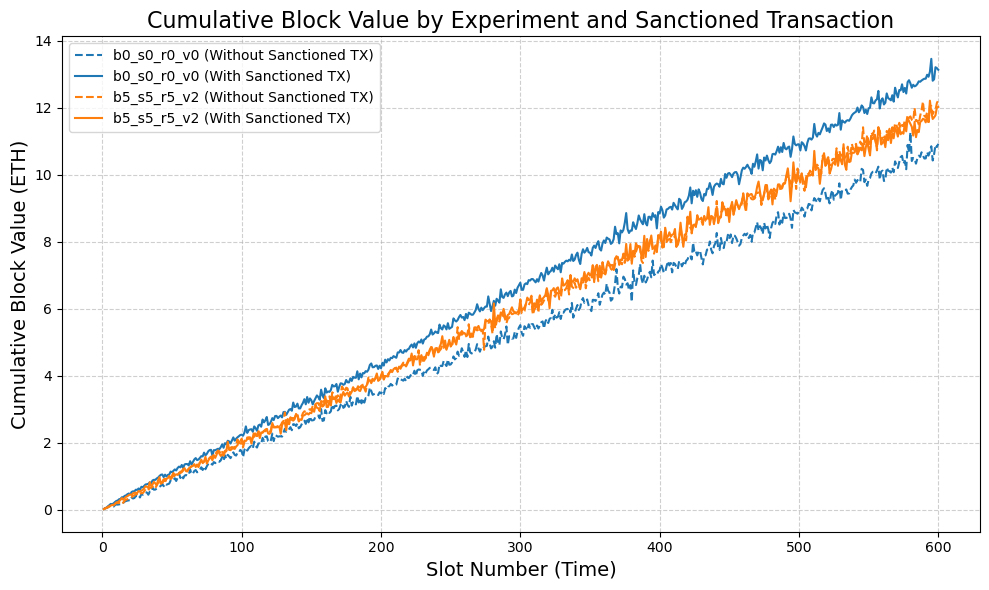

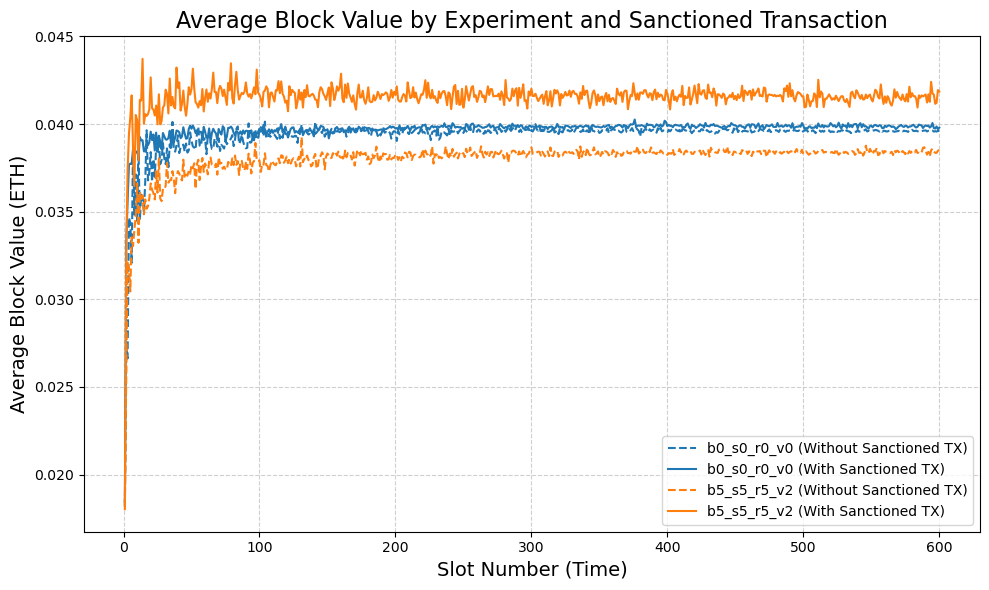

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and preprocess blocks.csv data
def load_blocks(filepath, experiment_label):
    df = pd.read_csv(filepath)
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()
    df['slot_no'] = df['slot_no'].astype(int)
    df['experiment'] = experiment_label
    df['contains_sanctioned'] = df['num_sanctioned_tx'] > 0
    
    return df

# Load block data from two experiments
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250607_215303_7200s/blocks.csv",
    'b0_s0_r0_v0'
)

blocks2 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250607_195134_7200s/blocks.csv",
    'b5_s5_r5_v2'
)

# Merge the two datasets
combined_blocks = pd.concat([blocks1, blocks2], ignore_index=True)

# First average within each run, then average across runs
# Compute and print total block value (converted to ETH) for blocks with/without TC transactions in each experiment
total_values = combined_blocks.groupby(['experiment', 'contains_sanctioned', 'run_id'])['total_priority_fee'].sum().div(1e9).groupby(['experiment', 'contains_sanctioned']).mean().reset_index()
print("Average total block value per run (ETH):")
print(total_values)

# Compute cumulative value per run_id and slot_no for blocks with/without TC transactions (converted to ETH)
combined_blocks.sort_values(['experiment', 'run_id', 'slot_no'], inplace=True)
combined_blocks['cum_priority_fee_eth'] = combined_blocks.groupby(['experiment', 'run_id', 'contains_sanctioned'])['total_priority_fee'].cumsum() / 1e9
combined_blocks['cum_block_count'] = combined_blocks.groupby(['experiment', 'run_id', 'contains_sanctioned']).cumcount() + 1
combined_blocks['avg_priority_fee_per_block_eth'] = combined_blocks['cum_priority_fee_eth'] / combined_blocks['cum_block_count']

# For each experiment and slot, compute average cumulative and per-block value across runs (ETH)
avg_cum_values = combined_blocks.groupby(['experiment', 'slot_no', 'contains_sanctioned']).agg({
    'cum_priority_fee_eth': 'mean',
    'avg_priority_fee_per_block_eth': 'mean'
}).reset_index()

# Labels
contains_label = {True: 'With Sanctioned TX', False: 'Without Sanctioned TX'}
color_map = {'b0_s0_r0_v0': "C0", 'b5_s5_r5_v2': "C1"}

# 1. Cumulative block value chart (ETH)
plt.figure(figsize=(10, 6))
for (experiment_label, contains), group in avg_cum_values.groupby(['experiment', 'contains_sanctioned']):
    plt.plot(
        group['slot_no'],
        group['cum_priority_fee_eth'],
        label=f"{experiment_label} ({contains_label[contains]})",
        color=color_map[experiment_label],
        linestyle='-' if contains else '--'
    )

plt.title('Cumulative Block Value by Experiment and Sanctioned Transaction', fontsize=16)
plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Cumulative Block Value (ETH)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Average block value chart (ETH)
plt.figure(figsize=(10, 6))
for (experiment_label, contains), group in avg_cum_values.groupby(['experiment', 'contains_sanctioned']):
    plt.plot(
        group['slot_no'],
        group['avg_priority_fee_per_block_eth'],
        label=f"{experiment_label} ({contains_label[contains]})",
        color=color_map[experiment_label],
        linestyle='-' if contains else '--'
    )

plt.title('Average Block Value by Experiment and Sanctioned Transaction', fontsize=16)
plt.xlabel('Slot Number (Time)', fontsize=14)
plt.ylabel('Average Block Value (ETH)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

### The average number of sanctioned_tx_ in the blocks containing sanctioned_tx

In [22]:
import pandas as pd

# Load Data
file_path1 = "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv"
file_path2 = "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv"

blocks1 = pd.read_csv(file_path1)
blocks2 = pd.read_csv(file_path2)

# Filtering（is_proposed=True）
blocks1 = blocks1[blocks1['is_proposed']]
blocks2 = blocks2[blocks2['is_proposed']]

# Calculate the average number of sanctioned_tx in blocks containing sanctioned_tx
for exp_name, blocks in [('b0_s0_r0_v0', blocks1), ('b5_s5_r5_v2', blocks2)]:
    sanctioned_blocks = blocks[blocks['num_sanctioned_tx'] > 0]
    avg_sanctioned_tx = sanctioned_blocks['num_sanctioned_tx'].mean()

    print(f"Experiment: {exp_name}")
    if sanctioned_blocks.empty:
        print("There is no blocks with sanctioned_tx.")
    else:
        print(f"The average number of sanctioned_tx in blocks containing sanctioned_tx: {avg_sanctioned_tx:.2f}")


Experiment: b0_s0_r0_v0
The average number of sanctioned_tx in blocks containing sanctioned_tx: 1.43
Experiment: b5_s5_r5_v2
The average number of sanctioned_tx in blocks containing sanctioned_tx: 1.65


Builder weights: {'19': 175, '18': 133, '17': 144, '16': 159, '15': 146, '14': 125, '13': 159, '12': 145, '11': 152, '10': 155, '9': 154, '8': 130, '7': 138, '6': 162, '5': 153, '4': 137, '3': 149, '2': 146, '1': 169, '0': 167}
Relay weights: {'9': 286, '8': 395, '7': 154, '6': 251, '5': 506, '4': 149, '3': 301, '2': 218, '1': 448, '0': 290}
Validator weights: {'9': 350, '8': 330, '7': 301, '6': 283, '5': 281, '4': 314, '3': 290, '2': 266, '1': 302, '0': 281}
[(('builder_0', 'relay_3', 'validator_8'), 29), (('builder_2', 'relay_9', 'validator_0'), 24), (('builder_1', 'relay_9', 'validator_0'), 23), (('builder_11', 'relay_8', 'validator_8'), 22), (('builder_19', 'relay_0', 'validator_3'), 21), (('builder_11', 'relay_5', 'validator_4'), 21), (('builder_9', 'relay_5', 'validator_9'), 20), (('builder_7', 'relay_5', 'validator_3'), 20), (('builder_1', 'relay_8', 'validator_9'), 20), (('builder_8', 'relay_8', 'validator_9'), 20)]
Total number of path occurrences: 2998


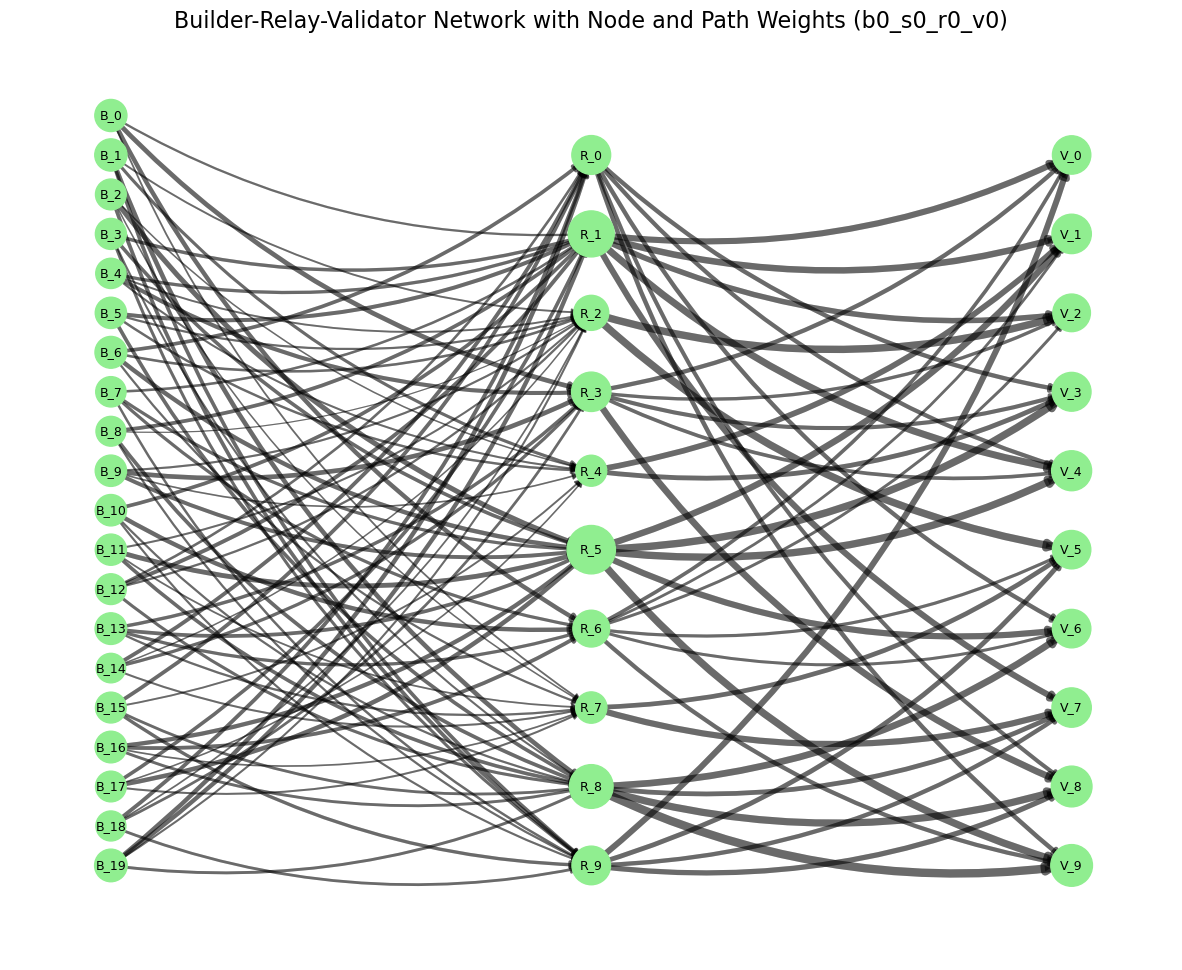

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D


# Load and preprocess blocks.csv data
def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath, dtype={
        'builder_id': str, 
        'selected_relay_id': str, 
        'proposer_validator_id': str
    })
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()

    # Remove spaces in ID fields
    df['builder_id'] = df['builder_id'].str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].str.strip().str.replace(r'\.0$', '', regex=True)
    df['proposer_validator_id'] = df['proposer_validator_id'].str.strip().str.replace(r'\.0$', '', regex=True)

    if tag is not None:
        df['experiment'] = tag

    return df

    
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b0_s0_r0_v0_uniform_start_20250608_131200_validation_1/blocks.csv",
    'b0_s0_r0_v0'
)

builder_weights = blocks1['builder_id'].value_counts().to_dict()
relay_weights = blocks1['selected_relay_id'].value_counts().to_dict()
validator_weights = blocks1['proposer_validator_id'].value_counts().to_dict()

# Sort the weight dictionaries by ID in descending order (for consistent plotting)
builder_weights_sorted = dict(sorted(builder_weights.items(), key=lambda x: int(x[0]), reverse=True))
relay_weights_sorted = dict(sorted(relay_weights.items(), key=lambda x: int(x[0]), reverse=True))
validator_weights_sorted = dict(sorted(validator_weights.items(), key=lambda x: int(x[0]), reverse=True))

print("Builder weights:", builder_weights_sorted)
print("Relay weights:", relay_weights_sorted)
print("Validator weights:", validator_weights_sorted)

# Construct path (builder → relay → validator)
blocks1['path'] = blocks1.apply(
    lambda row: (f'builder_{row["builder_id"]}', 
                 f'relay_{row["selected_relay_id"]}', 
                 f'validator_{row["proposer_validator_id"]}'), 
    axis=1
)

# Count the frequency of each path
path_weights = Counter(blocks1['path'])

# View the most common paths (example)
print(path_weights.most_common(10))
print(f"Total number of path occurrences: {sum(path_weights.values())}")


# Builder-to-relay and validator-to-relay mappings (b0_s0_r0_v0)
builder_relay_mapping = {
    "0": [6, 1, 3, 7],
    "1": [4, 8, 2, 9],
    "2": [7, 5, 4, 9],
    "3": [9, 1, 8, 5],
    "4": [3, 2, 1, 4],
    "5": [2, 8, 1, 4],
    "6": [5, 7, 0, 2],
    "7": [1, 9, 5, 6],
    "8": [1, 2, 8, 9],
    "9": [2, 5, 3, 4],
    "10": [6, 9, 8, 1],
    "11": [8, 5, 2, 7],
    "12": [8, 0, 1, 2],
    "13": [3, 6, 5, 7],
    "14": [3, 2, 7, 0],
    "15": [0, 4, 8, 9],
    "16": [5, 8, 6, 7],
    "17": [5, 7, 1, 4],
    "18": [2, 3, 9, 0],
    "19": [1, 0, 8, 2]
}

validator_relay_mapping = {
    "0": [6, 9, 1, 3],
    "1": [4, 1, 6, 5],
    "2": [2, 3, 1, 6],
    "3": [5, 4, 3, 0],
    "4": [0, 1, 5, 3],
    "5": [7, 9, 2, 6],
    "6": [8, 6, 5, 0],
    "7": [8, 1, 9, 7],
    "8": [3, 8, 0, 9],
    "9": [8, 5, 6, 0]
}

# Node policy definitions (b0_s0_r0_v0, all non-censoring)
builder_policies = {
    'strict': [],
    'weak': [],
    'non': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
}

relay_policies = {
    'censoring': [],
    'non': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
}

validator_policies = {
    True: [],
    False: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
}



# Create the graph
# G = nx.Graph()
G = nx.DiGraph()  # Directed graph with curved edges

# Explicit node order
builder_nodes = [f'builder_{id}' for id in builder_weights_sorted.keys()]
relay_nodes = [f'relay_{id}' for id in relay_weights_sorted.keys()]
validator_nodes = [f'validator_{id}' for id in validator_weights_sorted.keys()]

# Add nodes
for builder_id in builder_relay_mapping:
    G.add_node(f'builder_{builder_id}', type='builder')

for validator_id in validator_relay_mapping:
    G.add_node(f'validator_{validator_id}', type='validator')

relay_ids = set(sum(builder_relay_mapping.values(), []) + sum(validator_relay_mapping.values(), []))
for relay_id in relay_ids:
    G.add_node(f'relay_{relay_id}', type='relay')


# Initialize all edges
for builder_id, relays in builder_relay_mapping.items():
    for relay in relays:
        G.add_edge(f'builder_{builder_id}', f'relay_{relay}', weight=0)

for validator_id, relays in validator_relay_mapping.items():
    for relay in relays:
        G.add_edge(f'relay_{relay}', f'validator_{validator_id}', weight=0)

# Accumulate actual path weights
for (builder, relay, validator), weight in path_weights.items():
    G[builder][relay]['weight'] += weight
    G[relay][validator]['weight'] += weight


# Define base size and scale factor for clarity
base_size = 200
scale_factor = 2

# Recalculate node sizes based on sorted weight dictionary
builder_sizes = [
    base_size + builder_weights_sorted[node.split('_')[1]] * scale_factor
    for node in builder_nodes
]

relay_sizes = [
    base_size + relay_weights_sorted[node.split('_')[1]] * scale_factor
    for node in relay_nodes
]

validator_sizes = [
    base_size + validator_weights_sorted[node.split('_')[1]] * scale_factor
    for node in validator_nodes
]

# Get edge weights and set edge widths
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_width, max_width = 0.5, 6

# Edge width scaling function
def scale_width(weight):
    return min_width + (weight / max_weight) * (max_width - min_width)

edge_widths = [scale_width(w) for w in edge_weights]



# Draw network graph (with weights and hierarchical layout)
plt.figure(figsize=(15, 12))

# Define x-coordinate layers: 0, 1, 2
pos = {}
layers = {'builder': 0, 'relay': 1, 'validator': 2}



# Compute spacing based on number of nodes to avoid clutter
builder_spacing = 1
relay_spacing = 2
validator_spacing = 2

for i, node in enumerate(builder_nodes):
    pos[node] = (layers['builder'], i * builder_spacing)

for i, node in enumerate(relay_nodes):
    pos[node] = (layers['relay'], i * relay_spacing)

for i, node in enumerate(validator_nodes):
    pos[node] = (layers['validator'], i * validator_spacing)


# Define colors for each policy type
policy_colors = {
    'builder': {
        'strict': 'lightcoral',    
        'weak': 'khaki',           
        'non': 'lightgreen'       
    },
    'relay': {
        'censoring': 'lightcoral',  
        'non': 'lightgreen'        
    },
    'validator': {
        True: 'lightcoral',        
        False: 'lightgreen'         
    }
}

# Determine node color based on policy
node_color_mapping = {}
for policy, nodes in builder_policies.items():
    for node_id in nodes:
        node_color_mapping[f'builder_{node_id}'] = policy_colors['builder'][policy]

for policy, nodes in relay_policies.items():
    for node_id in nodes:
        node_color_mapping[f'relay_{node_id}'] = policy_colors['relay'][policy]

for policy, nodes in validator_policies.items():
    for node_id in nodes:
        node_color_mapping[f'validator_{node_id}'] = policy_colors['validator'][policy]


# Draw nodes with weights and policy colors
nx.draw_networkx_nodes(G, pos,
                       nodelist=builder_nodes,
                       node_color=[node_color_mapping[node] for node in builder_nodes],
                       node_size=builder_sizes, label='Builder')

nx.draw_networkx_nodes(G, pos,
                       nodelist=relay_nodes,
                       node_color=[node_color_mapping[node] for node in relay_nodes],
                       node_size=relay_sizes, label='Relay')

nx.draw_networkx_nodes(G, pos,
                       nodelist=validator_nodes,
                       node_color=[node_color_mapping[node] for node in validator_nodes],
                       node_size=validator_sizes, label='Validator')

# Draw weighted edges with curve
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_widths,
                       connectionstyle='arc3,rad=0.15', arrows=True)

# Draw labels (commented out for clarity)
labels = {
    node: f"B_{node.split('_')[1]}" if node.startswith('builder_') else
          f"R_{node.split('_')[1]}" if node.startswith('relay_') else
          f"V_{node.split('_')[1]}"
    for node in G.nodes
}

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Builder',
           markerfacecolor=policy_colors['builder']['non'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Relay',
           markerfacecolor=policy_colors['relay']['non'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Validator',
           markerfacecolor=policy_colors['validator'][False], markersize=10)
]

# plt.legend(handles=legend_elements, loc='upper right')


nx.draw_networkx_edges(G, pos, alpha=0.4, width=edge_widths,
                       connectionstyle='arc3,rad=0.15', arrowsize=10)


nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Builder-Relay-Validator Network with Node and Path Weights (b0_s0_r0_v0)", fontsize=16)
plt.axis('off')
# plt.legend(scatterpoints=1)
plt.show()


Builder weights: {'19': 218, '18': 207, '17': 209, '16': 202, '15': 201, '14': 216, '13': 265, '12': 212, '11': 200, '10': 219, '9': 53, '8': 22, '7': 59, '6': 63, '5': 37, '4': 93, '3': 107, '2': 132, '1': 147, '0': 135}
Relay weights: {'9': 556, '8': 327, '7': 482, '6': 680, '5': 330, '4': 91, '3': 166, '2': 104, '1': 63, '0': 198}
Validator weights: {'9': 350, '8': 330, '7': 301, '6': 283, '5': 281, '4': 314, '3': 290, '2': 266, '1': 302, '0': 280}
[(('builder_10', 'relay_6', 'validator_9'), 37), (('builder_18', 'relay_8', 'validator_4'), 32), (('builder_13', 'relay_6', 'validator_3'), 31), (('builder_13', 'relay_6', 'validator_5'), 31), (('builder_1', 'relay_1', 'validator_1'), 30), (('builder_13', 'relay_7', 'validator_7'), 30), (('builder_10', 'relay_6', 'validator_8'), 29), (('builder_13', 'relay_8', 'validator_2'), 29), (('builder_17', 'relay_5', 'validator_7'), 29), (('builder_12', 'relay_6', 'validator_4'), 28)]
Total number of path occurrences: 2997


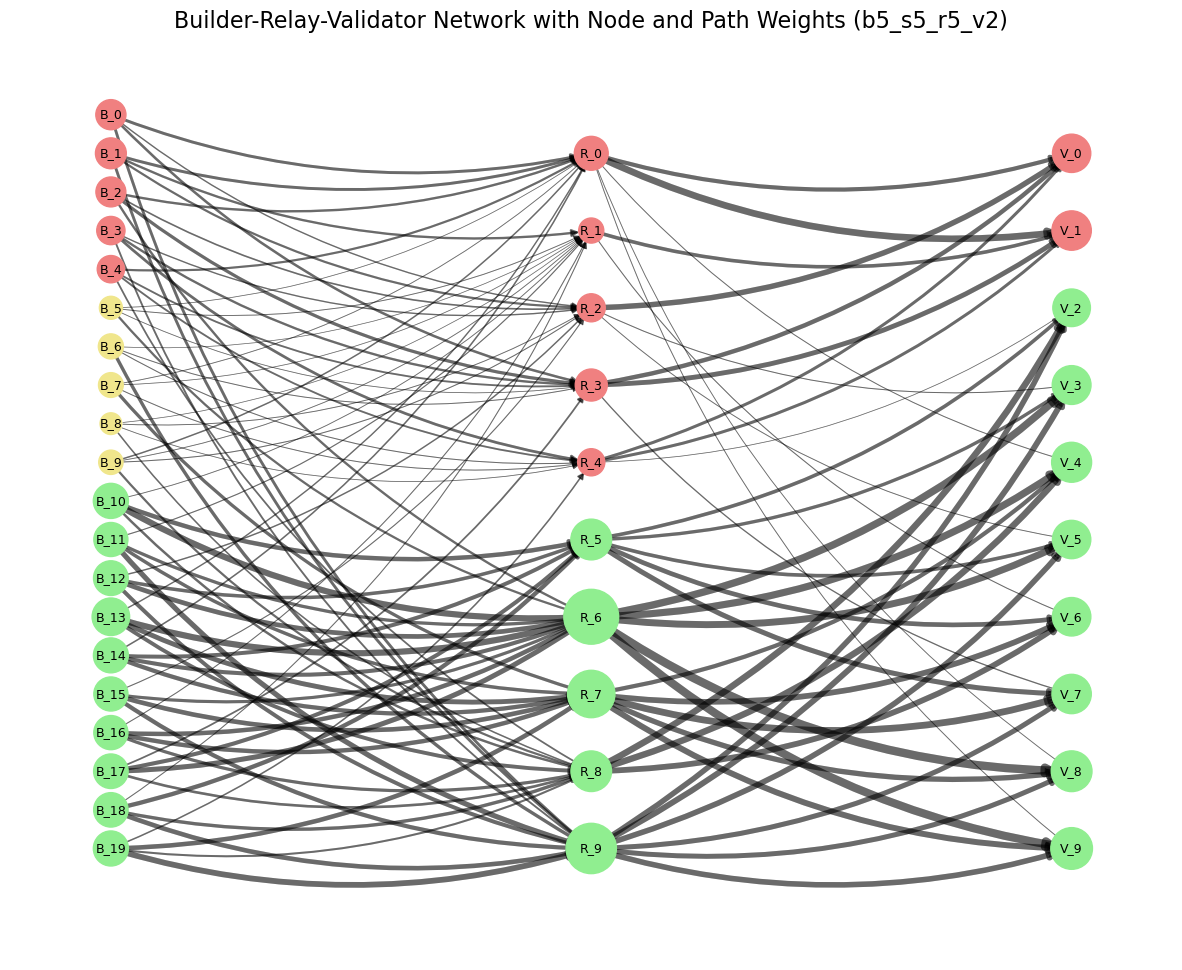

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D


# Load and preprocess blocks.csv data
def load_blocks(filepath, tag=None):
    df = pd.read_csv(filepath, dtype={
        'builder_id': str, 
        'selected_relay_id': str, 
        'proposer_validator_id': str
    })
    df = df[(df['is_proposed']) & (df['builder_id'] != 'PROPOSER')].copy()

    # Remove spaces in ID fields
    df['builder_id'] = df['builder_id'].str.strip()
    df['selected_relay_id'] = df['selected_relay_id'].str.strip().str.replace(r'\.0$', '', regex=True)
    df['proposer_validator_id'] = df['proposer_validator_id'].str.strip().str.replace(r'\.0$', '', regex=True)

    if tag is not None:
        df['experiment'] = tag

    return df

    
blocks1 = load_blocks(
    "simulation_results_validation_0606/baseline_b5_s5_r5_v2_uniform_start_20250608_134451_validation_2/blocks.csv",
    'b0_s0_r0_v0'
)

builder_weights = blocks1['builder_id'].value_counts().to_dict()
relay_weights = blocks1['selected_relay_id'].value_counts().to_dict()
validator_weights = blocks1['proposer_validator_id'].value_counts().to_dict()

# Sort the weight dictionaries by ID in descending order (for consistent plotting)
builder_weights_sorted = dict(sorted(builder_weights.items(), key=lambda x: int(x[0]), reverse=True))
relay_weights_sorted = dict(sorted(relay_weights.items(), key=lambda x: int(x[0]), reverse=True))
validator_weights_sorted = dict(sorted(validator_weights.items(), key=lambda x: int(x[0]), reverse=True))

print("Builder weights:", builder_weights_sorted)
print("Relay weights:", relay_weights_sorted)
print("Validator weights:", validator_weights_sorted)

# Construct path (builder → relay → validator)
blocks1['path'] = blocks1.apply(
    lambda row: (f'builder_{row["builder_id"]}', 
                 f'relay_{row["selected_relay_id"]}', 
                 f'validator_{row["proposer_validator_id"]}'), 
    axis=1
)

# Count the frequency of each path
path_weights = Counter(blocks1['path'])

# View the most common paths (example)
print(path_weights.most_common(10))
print(f"Total number of path occurrences: {sum(path_weights.values())}")


# Builder-to-relay and validator-to-relay mappings (b5_s5_r5_v2)
builder_relay_mapping = {
    "0": [3,0,2,9], "1": [1,0,2,9], "2": [2,3,0,6], "3": [2,3,4,9],
    "4": [4,3,0,8], "5": [0,3,1,6], "6": [3,4,1,9], "7": [0,4,1,7],
    "8": [4,1,2,8], "9": [1,0,2,8], "10": [1,5,8,6], "11": [7,1,9,6],
    "12": [2,6,9,5], "13": [0,6,7,8], "14": [0,5,6,7], "15": [6,9,2,7],
    "16": [1,7,6,8], "17": [3,8,6,5], "18": [5,8,1,9], "19": [4,7,8,9]
}


validator_relay_mapping = {
    "0": [2,3,0,4], "1": [0,1,4,3], "2": [4,5,9,8], "3": [2,5,9,6],
    "4": [8,0,6,7], "5": [6,9,2,5], "6": [7,1,8,5], "7": [5,3,7,9],
    "8": [0,6,9,7], "9": [0,9,6,7]
}

# Node policy definitions (b5_s5_r5_v2)
# Builder
builder_policies = {
    'strict': ['0', '1', '2', '3', '4'],
    'weak': ['5', '6', '7', '8', '9'],
    'non': ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
}

# Relay
relay_policies = {
    'censoring': ['0', '1', '2', '3', '4'],
    'non': ['5', '6', '7', '8', '9']
}

# Validator
validator_policies = {
    True: ['0', '1'],
    False: ['2', '3', '4', '5', '6', '7', '8', '9']
}


# Create the graph
# G = nx.Graph()
G = nx.DiGraph()  # Directed graph with curved edges

# Explicit node order
builder_nodes = [f'builder_{id}' for id in builder_weights_sorted.keys()]
relay_nodes = [f'relay_{id}' for id in relay_weights_sorted.keys()]
validator_nodes = [f'validator_{id}' for id in validator_weights_sorted.keys()]

# Add nodes
for builder_id in builder_relay_mapping:
    G.add_node(f'builder_{builder_id}', type='builder')

for validator_id in validator_relay_mapping:
    G.add_node(f'validator_{validator_id}', type='validator')

relay_ids = set(sum(builder_relay_mapping.values(), []) + sum(validator_relay_mapping.values(), []))
for relay_id in relay_ids:
    G.add_node(f'relay_{relay_id}', type='relay')


# Initialize all edges
for builder_id, relays in builder_relay_mapping.items():
    for relay in relays:
        G.add_edge(f'builder_{builder_id}', f'relay_{relay}', weight=0)

for validator_id, relays in validator_relay_mapping.items():
    for relay in relays:
        G.add_edge(f'relay_{relay}', f'validator_{validator_id}', weight=0)

# Accumulate actual path weights
for (builder, relay, validator), weight in path_weights.items():
    G[builder][relay]['weight'] += weight
    G[relay][validator]['weight'] += weight


# Define base size and scale factor for clarity
base_size = 200
scale_factor = 2

# Recalculate node sizes based on sorted weight dictionary
builder_sizes = [
    base_size + builder_weights_sorted[node.split('_')[1]] * scale_factor
    for node in builder_nodes
]

relay_sizes = [
    base_size + relay_weights_sorted[node.split('_')[1]] * scale_factor
    for node in relay_nodes
]

validator_sizes = [
    base_size + validator_weights_sorted[node.split('_')[1]] * scale_factor
    for node in validator_nodes
]

# Get edge weights and set edge widths
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(edge_weights)
min_width, max_width = 0.5, 6

# Edge width scaling function
def scale_width(weight):
    return min_width + (weight / max_weight) * (max_width - min_width)

edge_widths = [scale_width(w) for w in edge_weights]




# Draw network graph (with weights and hierarchical layout)
plt.figure(figsize=(15, 12))

# Define x-coordinate layers: 0, 1, 2
pos = {}
layers = {'builder': 0, 'relay': 1, 'validator': 2}



# Compute spacing based on number of nodes to avoid clutter
builder_spacing = 1
relay_spacing = 2
validator_spacing = 2

for i, node in enumerate(builder_nodes):
    pos[node] = (layers['builder'], i * builder_spacing)

for i, node in enumerate(relay_nodes):
    pos[node] = (layers['relay'], i * relay_spacing)

for i, node in enumerate(validator_nodes):
    pos[node] = (layers['validator'], i * validator_spacing)


# Define colors for each policy type
policy_colors = {
    'builder': {
        'strict': 'lightcoral',    
        'weak': 'khaki',           
        'non': 'lightgreen'        
    },
    'relay': {
        'censoring': 'lightcoral',  
        'non': 'lightgreen'         
    },
    'validator': {
        True: 'lightcoral',       
        False: 'lightgreen'         
    }
}


# Determine node color based on policy

node_color_mapping = {}
for policy, nodes in builder_policies.items():
    for node_id in nodes:
        node_color_mapping[f'builder_{node_id}'] = policy_colors['builder'][policy]

for policy, nodes in relay_policies.items():
    for node_id in nodes:
        node_color_mapping[f'relay_{node_id}'] = policy_colors['relay'][policy]

for policy, nodes in validator_policies.items():
    for node_id in nodes:
        node_color_mapping[f'validator_{node_id}'] = policy_colors['validator'][policy]


# Draw nodes with weights and policy colors
nx.draw_networkx_nodes(G, pos,
                       nodelist=builder_nodes,
                       node_color=[node_color_mapping[node] for node in builder_nodes],
                       node_size=builder_sizes)

nx.draw_networkx_nodes(G, pos,
                       nodelist=relay_nodes,
                       node_color=[node_color_mapping[node] for node in relay_nodes],
                       node_size=relay_sizes)

nx.draw_networkx_nodes(G, pos,
                       nodelist=validator_nodes,
                       node_color=[node_color_mapping[node] for node in validator_nodes],
                       node_size=validator_sizes)

# Draw weighted edges with curve
nx.draw_networkx_edges(G, pos, alpha=0.3, width=edge_widths,
                       connectionstyle='arc3,rad=0.15', arrows=True)

# Draw labels (commented out for clarity)
labels = {
    node: f"B_{node.split('_')[1]}" if node.startswith('builder_') else
          f"R_{node.split('_')[1]}" if node.startswith('relay_') else
          f"V_{node.split('_')[1]}"
    for node in G.nodes
}

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Builder',
           markerfacecolor=policy_colors['builder']['non'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Relay',
           markerfacecolor=policy_colors['relay']['non'], markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Validator',
           markerfacecolor=policy_colors['validator'][False], markersize=10)
]

# plt.legend(handles=legend_elements, loc='upper right')

nx.draw_networkx_edges(G, pos, alpha=0.4, width=edge_widths,
                       connectionstyle='arc3,rad=0.15', arrowsize=10)


nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

plt.title("Builder-Relay-Validator Network with Node and Path Weights (b5_s5_r5_v2)", fontsize=16)
plt.axis('off')
# plt.legend(scatterpoints=1)
plt.show()


In [ ]:
from graphviz import Digraph
import os
# Cannot align node order consistently, giving up, no impact on the result

# Create a directed graph object
dot = Digraph(comment='Builder-Relay-Validator Network', format='png')
dot.attr(ranksep='2.0', nodesep='0.1')  # Set node spacing

# Add builder nodes
builder_ids = [str(i) for i in range(20)]
with dot.subgraph(name='cluster_builders') as c:
    c.attr(style='filled', color='lightgoldenrod', label='Builders', rank='same',
           labelloc='t', labeljust='c', fontsize='16', fontcolor='black', fontname='Helvetica-bold')
    c.attr('node', shape='box', style='filled', fillcolor='white', fontcolor='black', fontsize='10')
    for b in sorted(builder_ids, key=int):
        c.node(f'builder_{b}', f'Builder {b}')

# Add relay nodes
relay_ids = [str(i) for i in range(10)]
with dot.subgraph(name='cluster_relays') as c:
    c.attr(style='filled', color='lightpink', label='Relays', rank='same',
           labelloc='t', labeljust='c', fontsize='16', fontcolor='black', fontname='Helvetica-bold')
    c.attr('node', shape='box', style='filled', fillcolor='white', fontcolor='black', fontsize='10')
    for r in sorted(relay_ids, key=int):
        c.node(f'relay_{r}', f'Relay {r}')


# Add validator nodes
validator_ids = [str(i) for i in range(10)]
with dot.subgraph(name='cluster_validators') as c:
    c.attr(style='filled', color='lavender', label='Validators', rank='same',
           labelloc='t', labeljust='c', fontsize='16', fontcolor='black', fontname='Helvetica-bold')
    c.attr('node', shape='box', style='filled', fillcolor='white', fontcolor='black', fontsize='10')
    for v in sorted(validator_ids, key=int):
        c.node(f'validator_{v}', f'Validator {v}')

# Add edges (builder → relay)
builder_relay_mapping = {
    "0": [6, 1, 3, 7], "1": [4, 8, 2, 9], "2": [7, 5, 4, 9], "3": [9, 1, 8, 5],
    "4": [3, 2, 1, 4], "5": [2, 8, 1, 4], "6": [5, 7, 0, 2], "7": [1, 9, 5, 6],
    "8": [1, 2, 8, 9], "9": [2, 5, 3, 4], "10": [6, 9, 8, 1], "11": [8, 5, 2, 7],
    "12": [8, 0, 1, 2], "13": [3, 6, 5, 7], "14": [3, 2, 7, 0], "15": [0, 4, 8, 9],
    "16": [5, 8, 6, 7], "17": [5, 7, 1, 4], "18": [2, 3, 9, 0], "19": [1, 0, 8, 2]
}

for b, relays in builder_relay_mapping.items():
    for r in relays:
        dot.edge(f'builder_{b}', f'relay_{r}')

# Add edges (relay → validator)
validator_relay_mapping = {
    "0": [6, 9, 1, 3], "1": [4, 1, 6, 5], "2": [2, 3, 1, 6], "3": [5, 4, 3, 0],
    "4": [0, 1, 5, 3], "5": [7, 9, 2, 6], "6": [8, 6, 5, 0], "7": [8, 1, 9, 7],
    "8": [3, 8, 0, 9], "9": [8, 5, 6, 0]
}

for v, relays in validator_relay_mapping.items():
    for r in relays:
        dot.edge(f'relay_{r}', f'validator_{v}')

# Specify the output folder and ensure it exists
output_dir = './graphs'
os.makedirs(output_dir, exist_ok=True)

# Output the graph image to the specified directory
dot.render(os.path.join(output_dir, 'network_diagram_b0_s0_r0_v0'), view=True)


'graphs/network_diagram_b0_s0_r0_v0.png'

In [ ]:
from graphviz import Digraph
import os
# Cannot align node order consistently, giving up, no impact on the result

# Create a directed graph object
dot = Digraph(comment='Builder-Relay-Validator Network b5_s5_r5_v2', format='png')
dot.attr(ranksep='2.0', nodesep='0.1')  # Set node spacing


# Builder Color Mapping
builder_colors = {
    'strict': 'lightcoral',
    'weak': 'khaki',
    'non': 'lightgreen'
}

# Relay Color Mapping
relay_colors = {
    'censoring': 'lightcoral',
    'non': 'lightgreen'
}

# Validator Color Mapping
validator_colors = {
    True: 'lightcoral',
    False: 'lightgreen'
}

# Builder Strategy Mapping
builder_policies = {
    'strict': ['0', '1', '2', '3', '4'],
    'weak': ['5', '6', '7', '8', '9'],
    'non': ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
}

# Relay Srategy Mapping
relay_policies = {
    'censoring': ['0', '1', '2', '3', '4'],
    'non': ['5', '6', '7', '8', '9']
}

# Validator Strategy Mapping
validator_policies = {
    True: ['0', '1'],
    False: ['2', '3', '4', '5', '6', '7', '8', '9']
}

# Add builder nodes
with dot.subgraph(name='cluster_builders') as c:
    c.attr(style='filled', color='lightgoldenrod', label='Builders', rank='same',
           labelloc='t', labeljust='c', fontsize='16', fontcolor='black', fontname='Helvetica-bold')
    c.attr('node', shape='box', style='filled', fontcolor='black', fontsize='10')
    for policy, ids in builder_policies.items():
        for b in ids:
            c.node(f'builder_{b}', f'Builder {b}', fillcolor=builder_colors[policy])

# Add relay nodes
with dot.subgraph(name='cluster_relays') as c:
    c.attr(style='filled', color='lightpink', label='Relays', rank='same',
           labelloc='t', labeljust='c', fontsize='16', fontcolor='black', fontname='Helvetica-bold')
    c.attr('node', shape='box', style='filled', fontcolor='black', fontsize='10')
    for policy, ids in relay_policies.items():
        for r in ids:
            c.node(f'relay_{r}', f'Relay {r}', fillcolor=relay_colors[policy])

# Add validator nodes
with dot.subgraph(name='cluster_validators') as c:
    c.attr(style='filled', color='lavender', label='Validators', rank='same',
           labelloc='t', labeljust='c', fontsize='16', fontcolor='black', fontname='Helvetica-bold')
    c.attr('node', shape='box', style='filled', fontcolor='black', fontsize='10')
    for policy, ids in validator_policies.items():
        for v in ids:
            c.node(f'validator_{v}', f'Validator {v}', fillcolor=validator_colors[policy])

# Add edges (builder → relay)
builder_relay_mapping = {
    "0": [3,0,2,9], "1": [1,0,2,9], "2": [2,3,0,6], "3": [2,3,4,9],
    "4": [4,3,0,8], "5": [0,3,1,6], "6": [3,4,1,9], "7": [0,4,1,7],
    "8": [4,1,2,8], "9": [1,0,2,8], "10": [1,5,8,6], "11": [7,1,9,6],
    "12": [2,6,9,5], "13": [0,6,7,8], "14": [0,5,6,7], "15": [6,9,2,7],
    "16": [1,7,6,8], "17": [3,8,6,5], "18": [5,8,1,9], "19": [4,7,8,9]
}

for b, relays in builder_relay_mapping.items():
    for r in relays:
        dot.edge(f'builder_{b}', f'relay_{r}')

# Add edges (relay → validator)
validator_relay_mapping = {
    "0": [2,3,0,4], "1": [0,1,4,3], "2": [4,5,9,8], "3": [2,5,9,6],
    "4": [8,0,6,7], "5": [6,9,2,5], "6": [7,1,8,5], "7": [5,3,7,9],
    "8": [0,6,9,7], "9": [0,9,6,7]
}

for v, relays in validator_relay_mapping.items():
    for r in relays:
        dot.edge(f'relay_{r}', f'validator_{v}')

# Specify the output folder and ensure it exists
output_dir = './graphs'
os.makedirs(output_dir, exist_ok=True)

# Output the graph image to the specified directory
dot.render(os.path.join(output_dir, 'network_diagram_b5_s5_r5_v2'), view=True)

'graphs/network_diagram_b5_s5_r5_v2.png'